In [23]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from wrangle import wrangle_hud
import preprocessing

In [45]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Acquire
All functions are called in `wrangle.py` file.
## Functions
- `acquire_fha_data.py` - This function takes fha data from hud website (url, sheet_name) turns it into pandas df.
    - url = https://www.hud.gov/sites/dfiles/Housing/documents/Initi_Endores_Firm%20Comm_DB_FY06_FY20_Q2.xlsx
    - sheet_name = "Firm Cmtmts, Iss'd and Reiss'd"
    - The dataset can be physically found at https://www.hud.gov/program_offices/housing/mfh/mfdata/mfproduction

# Prepare
All functions are called in `wrangle.py` file


## Functions

- `drop_multiple_fha_numbers` - Drops repeat entries by taking the most recent option
- `snake_case_column_names` - makes column names snake case
- `change_to_bool` - changes columns with [0, Y] values to bool (Y= True)
- `changing_data_types` - changes dtypes for datetime and turn fha_number into an object
- `make_activity_construction_bool` - makes boolean columns for is_refinance and is_new_construction
- `wrangle_hud` - mother function that also removes lower outlier and does some minor cell changes

In [46]:
df = wrangle_hud()

## Data Summary

In [47]:
print (f'This data frame is {df.shape[0]} rows and {df.shape[1]} columns.')
print ('Currently, each observation is one mortgage, which will change for modelling')
print()
print()
df.info()

This data frame is 20409 rows and 31 columns.
Currently, each observation is one mortgage, which will change for modelling


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20409 entries, 0 to 20514
Data columns (total 31 columns):
fha_number                                                              20409 non-null object
project_name                                                            20409 non-null object
project_city                                                            20409 non-null object
project_state                                                           20409 non-null object
basic_fha_risk_share_or_other                                           20409 non-null object
program_category                                                        20409 non-null object
activity_description                                                    20409 non-null object
activity_group                                                          20409 non-null object
facility_type 

In [48]:
df.head(2)

,fha_number,project_name,project_city,project_state,basic_fha_risk_share_or_other,program_category,activity_description,activity_group,facility_type,program_designation,...,tax_exempt_bond_designation,home_designation,cdbg_designation,section_202_refi_designation,irp_decoupling_designation,hope_vi_designation,current_status,final_mortgage_amount,is_refinance,is_new_construction
0,11345004,Western Heights Apartments,Olney,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,...,False,False,False,False,False,False,Firm Comit then Owner Withdrew,271700,True,False
1,11345005,Woodlands Village Apts,Breckenridge,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,...,False,False,False,False,False,False,Finally Endorsed,168300,True,False


Text(0.5, 1.0, 'Histogram of Mortgages by Year')

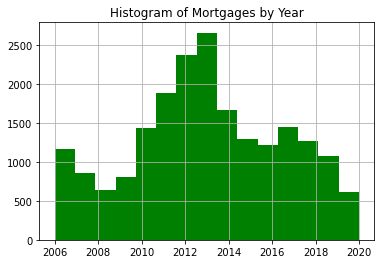

In [49]:
df.fiscal_year_of_firm_commitment_activity.hist(color='green', bins=15)
plt.title('Histogram of Mortgages by Year')

Text(0, 0.5, '')

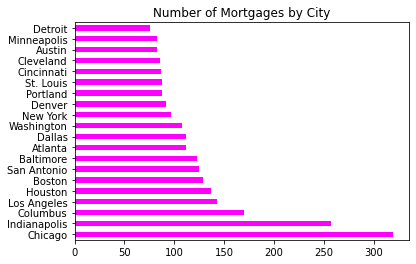

In [50]:
df.groupby('project_city').final_mortgage_amount.count().nlargest(20).plot.barh(color='magenta')
plt.title('Number of Mortgages by City')
plt.ylabel("")

Text(0.5, 1.0, 'Outliers Skewing Mortgage amount Data')

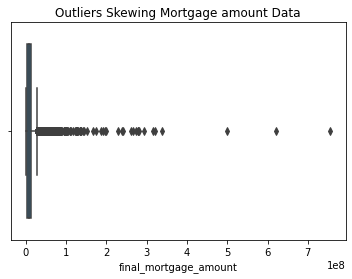

In [51]:
sns.boxplot(df.final_mortgage_amount)
plt.title("Outliers Skewing Mortgage amount Data")

In [63]:
mean_diff = df.final_mortgage_amount.mean()-df.final_mortgage_amount.median()
print(f'The difference between the mean and the median is {round(mean_diff)}')

df.final_mortgage_amount.describe()

The difference between the mean and the median is 4063026


count       20409.00
mean     10785326.03
std      15642874.34
min         70100.00
25%       3420500.00
50%       6722300.00
75%      13295800.00
max     755874500.00
Name: final_mortgage_amount, dtype: float64

# Exploration